<a href="https://colab.research.google.com/github/AnuragRao1/PredictMusicGenre/blob/main/PredictMusicGenre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

#download dataset
! kaggle datasets download vicsuperman/prediction-of-music-genre
! unzip prediction-of-music-genre.zip

df = pd.read_csv("music_genre.csv")
df
df.columns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 199MB/s]
Archive:  prediction-of-music-genre.zip
  inflating: music_genre.csv         


Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

In [2]:
#CLEAN DATASET
#drop unnecessary columns
df.drop(['instance_id','artist_name','track_name','key','mode','obtained_date'], inplace = True, axis = 1)
df

#drop outlier rows where duration_ms = -1
df.drop(df[df['duration_ms'] == -1.0].index, inplace = True)
df

#drop outlier rows where tempo = ?
df.drop(df[df['tempo'] == '?'].index, inplace = True)
df

#dropping null rows
df.isnull().sum()
df.drop(df[df.isnull().any(axis=1)].index, inplace = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40560 entries, 1 to 50004
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        40560 non-null  float64
 1   acousticness      40560 non-null  float64
 2   danceability      40560 non-null  float64
 3   duration_ms       40560 non-null  float64
 4   energy            40560 non-null  float64
 5   instrumentalness  40560 non-null  float64
 6   liveness          40560 non-null  float64
 7   loudness          40560 non-null  float64
 8   speechiness       40560 non-null  float64
 9   tempo             40560 non-null  object 
 10  valence           40560 non-null  float64
 11  music_genre       40560 non-null  object 
dtypes: float64(10), object(2)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40560 entries, 1 to 50004
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            -

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.5631848566756203

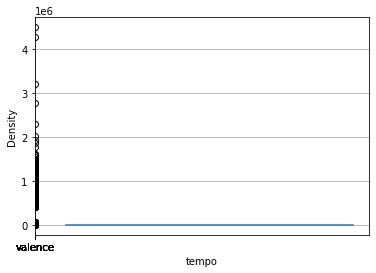

In [3]:
from seaborn.matrix import heatmap
from numpy.ma.core import correlate
#EDA
df.info()
df.describe()

#convert tempo column into a floater
df['tempo'] = pd.to_numeric(df['tempo'])
df.info()


#finding variables with many outliers
ammended_df = df.loc[:, df.columns != 'music_genre'] #get df without music_genre column
len(ammended_df.columns)
for i in range(1,11):
    ammended_df.boxplot(column = ammended_df.columns[i])  #popularity,instrumentalness,duration_ms,liveness,loudness,speechiness many outliers



#histogram
sns.distplot(df['tempo'])
df['tempo'].skew()
df['tempo'].kurt()




In [4]:
#MODEL
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state=0) #splits data
numcat = df.columns[0:11] #takes numerical categories

In [5]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth= 25000)
dtc.fit(train[numcat], train['music_genre'].values.reshape(-1,1))
dtc.score(train[numcat],train['music_genre']) 
dtc.score(test[numcat],test['music_genre']) 

0.4349112426035503

In [7]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
forst = RandomForestClassifier(n_estimators = 300)
forst.fit(train[numcat],train['music_genre'])
forst.score(train[numcat],train['music_genre'])
forst.score(test[numcat],test['music_genre'])


0.5506656804733728

In [50]:
#Gradient Boosted trees
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier()
grad.fit(train[numcat],train['music_genre'])
grad.score(train[numcat],train['music_genre']) 
grad.score(test[numcat],test['music_genre'])


0.5774161735700197

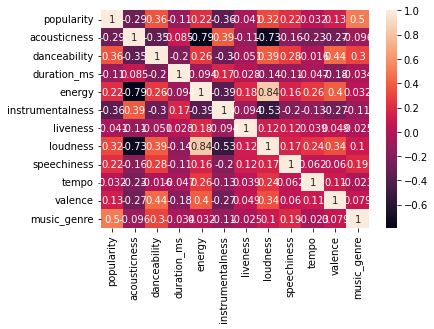

In [6]:
###More data analysis
#convert music_genre into integer values
from sklearn.preprocessing import OrdinalEncoder
dfn = df.copy()
dfn[['music_genre']] = OrdinalEncoder().fit_transform(dfn[['music_genre']])

#finding most correlated variables
corrmap = dfn.corr()
feature = corrmap.index

#plot heat map
sns.heatmap(dfn[feature].corr(), annot = True)
corrmap['music_genre']


# this gives us the most correlated variables of danceability, popularity,loudness,speechiness, instrumentalness, acousticness
good_features = ['danceability','popularity','loudness','speechiness','instrumentalness', 'acousticness','music_genre']




In [15]:
##Build new model with heavily correlated variables
train_g = train[good_features]
test_g = test[good_features]
numgf = train_g.columns[1:6] #takes numerical columns


In [36]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
dtc1 = DecisionTreeClassifier(max_depth= 25000)
dtc1.fit(train_g[numgf], train_g['music_genre'])
dtc1.score(train_g[numgf], train_g['music_genre']) 
dtc1.score(test_g[numgf], test_g['music_genre']) 


0.3827662721893491

In [7]:
#Genre data analysis
#simplify problem, pull genres
output = []
for x in df['music_genre']:
  if x not in output:
    output.append(x)
output

#genre analysis

#boxplot by genre
sns.boxplot(df['music_genre'],df['acousticness'])

#skew by genre and attribute
genskew = {}
col = df.columns.values[1:11]
col
for x in output:
  genskew[x] = {}
  for y in col:
    xdf = df[df['music_genre'] == x]
    genskew[x][y] = xdf[y].skew()
genskew

#kurtosis by genre and attribute
genkurt = {}
for x in output:
  genkurt[x] = {}
  for y in col:
    xdf = df[df['music_genre'] == x]
    genkurt[x][y] = xdf[y].kurt()
genkurt

['Electronic',
 'Anime',
 'Jazz',
 'Alternative',
 'Country',
 'Rap',
 'Blues',
 'Rock',
 'Classical',
 'Hip-Hop']

In [59]:
#create a dataframe for ridding genres
df_genre = df.copy()
df_genre.drop(df_genre[df_genre['music_genre'] == 'Hip-Hop'].index, inplace = True)
df_genre

#train/test split
train_genre, test_genre = train_test_split(df_genre, test_size = 0.2, random_state=0) 
numcat = df_genre.columns[0:11] #takes numerical categories

In [40]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtc_genre = DecisionTreeClassifier(max_depth= 25000)
dtc_genre.fit(train_genre[numgf], train_genre['music_genre'])
dtc_genre.score(train_genre[numgf], train_genre['music_genre'])
dtc_genre.score(test_genre[numgf], test_genre['music_genre']) 


0.45465761875385563

In [42]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
forst = RandomForestClassifier(n_estimators = 300)
forst.fit(train_genre[numgf], train_genre['music_genre'])
forst.score(train_genre[numgf], train_genre['music_genre'])
forst.score(test_genre[numgf], test_genre['music_genre'])

RandomForestClassifier(n_estimators=300)

In [64]:
#Gradient Boosted trees
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier()
grad.fit(train_genre[numgf], train_genre['music_genre'])
grad.score(train_genre[numgf], train_genre['music_genre']) 
grad.score(train_genre[numgf], train_genre['music_genre'])


0.6079284588501336